In [1]:
import torch
import torchvision

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from modular import get_data, get_data_details

get_data.get_data(data_path="data/food-101", folder="pizza_steak_sushi.zip")
get_data_details.get_data_details(folder="data/food-101")

Path already exists
test
steak:19
sushi:31
pizza:25
train
steak:75
sushi:72
pizza:78


In [3]:
os.listdir()

['pizza_steak_sushi.zip', 'test', '04-pizza-dad.jpeg', 'train']

### Manual transform

In [4]:
from torchvision import transforms

manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [5]:
from torchvision.datasets import ImageFolder

train_imagefolder = ImageFolder(root="train", transform=manual_transforms, target_transform=None)

test_imagefolder = ImageFolder(root="train", transform=manual_transforms, target_transform=None)

train_imagefolder, test_imagefolder

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_imagefolder, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_imagefolder, batch_size=32, shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x135d3e7b0>,
 <torch.utils.data.dataloader.DataLoader at 0x135c72c10>)

In [7]:
X, y = next(iter(train_dataloader))

X.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

### Auto transforms

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
train_imagefolder = ImageFolder(root="train", transform=auto_transforms, target_transform=None)
test_imagefolder = ImageFolder(root="train", transform=auto_transforms, target_transform=None)

train_dataloader = DataLoader(dataset=train_imagefolder, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_imagefolder, batch_size=32, shuffle=True)

train_imagefolder, test_imagefolder

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ))

In [11]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = torchvision.models.efficientnet_b0(weights=weights).to(device=device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
sum(torch.numel(i) for i in model.parameters()), sum(torch.numel(i) for i in model.parameters() if i.requires_grad)

(5288548, 5288548)

In [13]:
from torchinfo import summary

summary(model=model, input_size=(32, 3, 224, 224), device=device, col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential: 2-2  

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [15]:
for param in model.features.parameters():
    param.requires_grad = False

In [16]:
output_shape = len(train_imagefolder.classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [18]:
sum(torch.numel(i) for i in model.parameters())

4011391

In [19]:
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable']
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

In [20]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2)

loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     weight_decay: 0
 ))

In [21]:
%%time

from modular import engine
from sklearn.metrics import accuracy_score

batch_train_losses, batch_train_accuracies, batch_test_losses, batch_test_accuracies = engine.train(epochs=100, model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_score, device=device)

  1%|          | 1/100 [00:07<12:53,  7.82s/it]

Epoch: 0, Train Loss: 0.9017923474311829, Train Accuracy: 0.625, Test Loss: 0.20904269814491272, Test Accuracy: 0.9453125


 11%|█         | 11/100 [00:35<04:08,  2.79s/it]

Epoch: 10, Train Loss: 0.385290265083313, Train Accuracy: 0.80078125, Test Loss: 0.02444852888584137, Test Accuracy: 1.0


 21%|██        | 21/100 [01:03<03:44,  2.84s/it]

Epoch: 20, Train Loss: 0.18434898555278778, Train Accuracy: 0.85546875, Test Loss: 0.005845052655786276, Test Accuracy: 1.0


 31%|███       | 31/100 [01:32<03:19,  2.89s/it]

Epoch: 30, Train Loss: 1.0350953340530396, Train Accuracy: 0.8671875, Test Loss: 0.060420289635658264, Test Accuracy: 0.97265625


 41%|████      | 41/100 [02:03<03:07,  3.18s/it]

Epoch: 40, Train Loss: 0.28470754623413086, Train Accuracy: 0.86328125, Test Loss: 0.0050604273565113544, Test Accuracy: 1.0


 51%|█████     | 51/100 [02:33<02:27,  3.02s/it]

Epoch: 50, Train Loss: 0.82135009765625, Train Accuracy: 0.84375, Test Loss: 0.022148601710796356, Test Accuracy: 1.0


 61%|██████    | 61/100 [03:03<01:59,  3.05s/it]

Epoch: 60, Train Loss: 0.6265801191329956, Train Accuracy: 0.83203125, Test Loss: 0.0008966301684267819, Test Accuracy: 1.0


 71%|███████   | 71/100 [03:35<01:31,  3.16s/it]

Epoch: 70, Train Loss: 0.6437414884567261, Train Accuracy: 0.84375, Test Loss: 0.008794579654932022, Test Accuracy: 1.0


 81%|████████  | 81/100 [04:07<00:59,  3.13s/it]

Epoch: 80, Train Loss: 0.6854041218757629, Train Accuracy: 0.86328125, Test Loss: 0.0023466015700250864, Test Accuracy: 1.0


 91%|█████████ | 91/100 [04:38<00:28,  3.13s/it]

Epoch: 90, Train Loss: 0.3864745795726776, Train Accuracy: 0.8515625, Test Loss: 0.0007841307669878006, Test Accuracy: 1.0


100%|██████████| 100/100 [05:07<00:00,  3.07s/it]

CPU times: user 16min 40s, sys: 1min 18s, total: 17min 58s
Wall time: 5min 7s


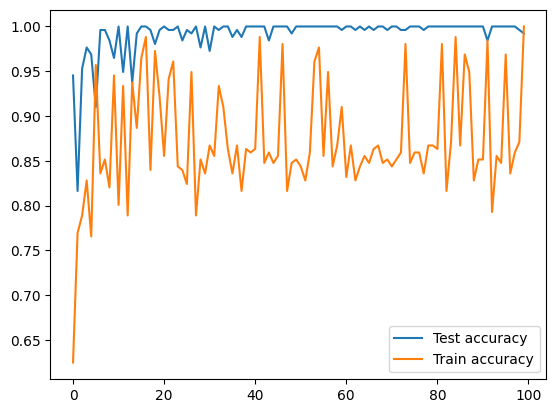

In [24]:
import matplotlib.pyplot as plt

plt.plot(batch_test_accuracies, label="Test accuracy")
plt.plot(batch_train_accuracies, label="Train accuracy")

plt.legend()

plt.show()

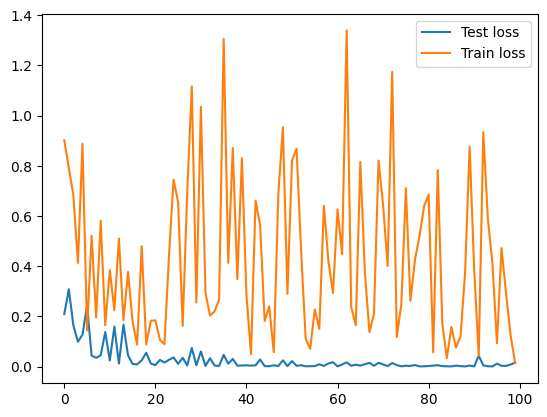

In [26]:
plt.plot([i.cpu().detach() for i in batch_test_losses], label="Test loss")
plt.plot([i.cpu().detach() for i in batch_train_losses], label="Train loss")

plt.legend()

plt.show()

In [28]:
from modular import save_model

save_model.save_model(model=model, name="../../models/efficientnet_b0.pth")

Model saved! Check at ../../models/efficientnet_b0.pth


## Making predictions

In [40]:
from PIL import Image
file = "04-pizza-dad.jpeg"

img = torchvision.io.read_image(file)
img = img.type(torch.float)
img /= 255
img = auto_transforms(img)
img = img.unsqueeze(dim=0)
img, img.shape

(tensor([[[[ 0.6580,  0.1713,  0.5228,  ..., -1.4387, -1.7786, -1.8627],
           [-0.3894,  0.6988,  0.5292,  ..., -1.5781, -1.7865, -1.8425],
           [-0.3020,  0.2183,  1.2623,  ..., -1.6526, -1.7122, -1.8090],
           ...,
           [-1.1590, -1.6358, -1.7978,  ..., -0.7224, -0.7549, -0.7265],
           [-1.4792, -1.6383, -1.7338,  ..., -0.7557, -0.8153, -0.7866],
           [-1.3646, -1.5740, -1.6655,  ..., -0.7267, -0.7663, -0.7499]],
 
          [[ 0.9854,  0.4889,  0.8445,  ..., -1.2368, -1.5656, -1.6514],
           [-0.1026,  0.9816,  0.8052,  ..., -1.3366, -1.5644, -1.6324],
           [-0.0113,  0.5104,  1.5412,  ..., -1.3878, -1.4800, -1.5991],
           ...,
           [-1.3286, -1.6795, -1.8138,  ..., -1.0650, -1.0793, -1.0289],
           [-1.5873, -1.6698, -1.7272,  ..., -1.0700, -1.1212, -1.0938],
           [-1.4773, -1.6274, -1.6952,  ..., -1.0526, -1.0919, -1.0822]],
 
          [[ 0.7617,  0.2420,  0.6356,  ..., -1.1230, -1.4590, -1.5442],
           [-

In [45]:
model.eval()

with torch.inference_mode():
    result = model(img.to(device=device))

preds = torch.softmax(result, dim=1)
pred = torch.argmax(preds, dim=1)
prob = preds[pred][0][pred]
output_class = train_imagefolder.classes[pred]

pred, prob, output_class

(tensor([0], device='mps:0'), tensor([0.9941], device='mps:0'), 'pizza')

99% accuracy